## Single Decision Maker (UNOS) Q-Learning

Episode 1/10000
Episode 501/10000
Episode 1001/10000
Episode 1501/10000
Episode 2001/10000
Episode 2501/10000
Episode 3001/10000
Episode 3501/10000
Episode 4001/10000
Episode 4501/10000
Episode 5001/10000
Episode 5501/10000
Episode 6001/10000
Episode 6501/10000
Episode 7001/10000
Episode 7501/10000
Episode 8001/10000
Episode 8501/10000
Episode 9001/10000
Episode 9501/10000


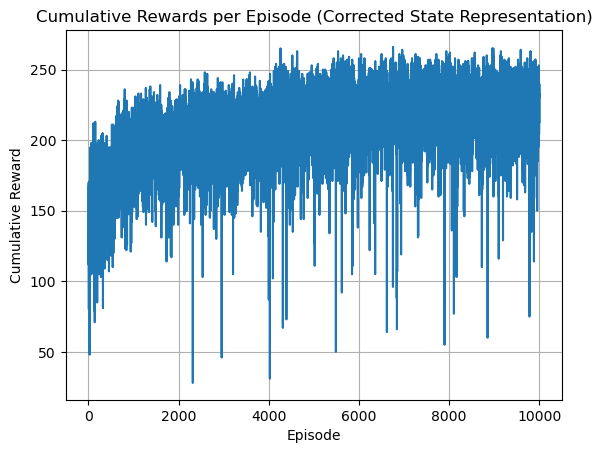

In [73]:
# Updated implementation with corrected state space (matched organs)
# Re-initialize environment parameters
import itertools
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# Environment parameters
num_groups = 3  # Patient groups: Low Risk, Medium Risk, High Risk
total_organs = 50  # Initial organ supply
time_horizon = 30  # Ischemic time limit (discrete time steps)
num_episodes = 10000  # Number of Q-learning episodes

epsilon = 0.8
alpha = 0.9
gamma = 0.99
# Patient group parameters
alpha_params = [5, 25, 9]  # Alpha parameters for urgency Beta distribution
beta_params = [25, 10, 1]  # Beta parameters for urgency Beta distribution

# Action space: Prioritization levels for all groups (bounded [0, 10])
actions = list(itertools.product(range(11), repeat=num_groups))  # Joint actions

# Q-table
Q_table = {}


# Patient group parameters
alpha_params = [5, 25, 9]  # Alpha parameters for urgency Beta distribution
beta_params = [25, 10, 1]  # Beta parameters for urgency Beta distribution

# Action space: Prioritization levels for all groups (bounded [0, 10])
actions = list(itertools.product(range(11), repeat=num_groups))  # Joint actions

# Q-table
Q_table = {}

# Define urgency sampling function
def sample_urgency(group_id):
    alpha, beta = alpha_params[group_id], beta_params[group_id]
    return np.round(np.random.beta(alpha, beta) * 10, 2)  # Scaled urgency [0, 10]


# Define state-to-key helper based on new representation
def state_to_key(state):
    return (
        state["time"],  # Current time step
        state["organs"],  # Remaining organ count
        tuple(group["matched_organs"] for group in state["patient_groups"]),  # Organs matched in the previous step
    )

# Define initial state (joint state space)
def initialize_state():
    return {
        "time": 0,  # Start at time step 0
        "organs": total_organs,  # Initial organ supply
        "patient_groups": [
            {"matched_organs": 0}  # Initially no organs matched for each group
            for _ in range(num_groups)
        ],
    }

# Updated transition model based on matched organs
def transition(state, action):
    allocate = {}
    #need to do allocation 
    for group_id, priority in enumerate(action): #for each group id sample loop through get num patients for each patients sample urgency 
        urgency = sample_urgency(group_id) #for now each group has 1 'new person'
        if urgency > priority:
            allocate[group_id] = 1 #get an organ
        else: 
            allocate[group_id] = 0 #don't get an organ
    
    new_state = {
        "time": state["time"] + 1,  # Increment time step
        "organs": max(0, state["organs"] - sum(allocate.values())),  # Update remaining organ count
        "patient_groups": [],
    }
    reward = 0
    
    
    # Update matched organs for each group based on the action
    for group_id, matched_organs in allocate.items():
        new_state["patient_groups"].append({"matched_organs": matched_organs})
        if matched_organs > 0: 
            reward += matched_organs*action[group_id]
    
    if state['organs'] < 0: 
        reward -= 200
    

    return new_state, reward


# Initialize Q-table dynamically
def initialize_Q(state):
    key = state_to_key(state)
    if key not in Q_table:
        Q_table[key] = {a: 0 for a in actions}

# Re-run Q-learning loop with the corrected state representation
rewards_per_episode = []

for episode in range(num_episodes):
    if episode % 500 == 0:
        print(f"Episode {episode+1}/{num_episodes}")
    state = initialize_state()  # Start from the initial state
    total_reward = 0

    for t in range(time_horizon):
        # Convert state to key and initialize Q-table entry if needed
        #print(state)
        key = state_to_key(state)
        initialize_Q(state)

        # Choose an action (epsilon-greedy policy)
        if random.uniform(0, 1) < epsilon:
            action = random.choice(actions)  # Explore
        else:
            action = max(Q_table[key], key=Q_table[key].get)  # Exploit
            
        #print(f"action is {action}")

        # Simulate environment
        next_state, reward = transition(state, action)
        next_key = state_to_key(next_state)
        initialize_Q(next_state)  # Initialize next state in Q-table if needed

        # Update Q-value using the Bellman equation
        best_next_action = max(Q_table[next_key], key=Q_table[next_key].get)
        Q_table[key][action] += alpha * (
            reward + gamma * Q_table[next_key][best_next_action] - Q_table[key][action]
        )
        #print(Q_table[next_key][best_next_action])

        state = next_state
        total_reward += reward
        
        if state['organs'] <= 0: 
            #print("used up all the organs")
            break

    rewards_per_episode.append(total_reward)
    epsilon = max(0.1, epsilon * 0.99)  # Decay epsilon

# Convert Q-table to DataFrame for analysis
policy_df = pd.DataFrame.from_dict(Q_table, orient="index")


# Plot cumulative rewards per episode
plt.plot(rewards_per_episode)
plt.title("Cumulative Rewards per Episode (Corrected State Representation)")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.grid()
plt.show()

## Single Decision Maker
Adding in multiple patients

Episode 1/5000
Episode 501/5000
Episode 1001/5000
Episode 1501/5000
Episode 2001/5000
Episode 2501/5000
Episode 3001/5000
Episode 3501/5000
Episode 4001/5000
Episode 4501/5000


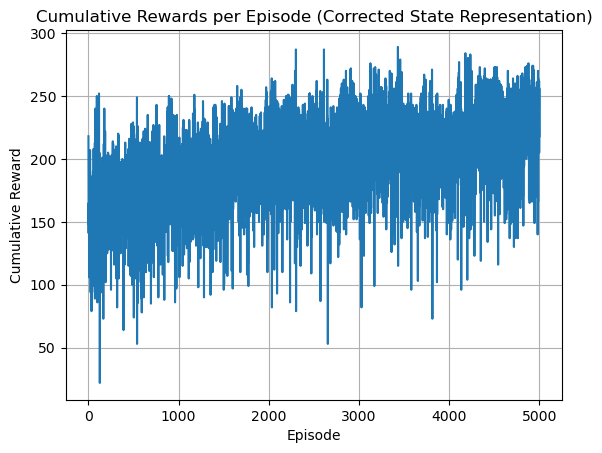

In [76]:
# Updated implementation with corrected state space (matched organs)
# Re-initialize environment parameters
import itertools
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# Environment parameters
num_groups = 3  # Patient groups: Low Risk, Medium Risk, High Risk
total_organs = 50  # Initial organ supply
time_horizon = 30  # Ischemic time limit (discrete time steps)
num_episodes = 5000 # Number of Q-learning episodes

patients_per_group = {1: 1, 2: 2, 3:3 }

epsilon = 0.8
alpha = 0.9
gamma = 0.99
# Patient group parameters
alpha_params = [5, 25, 9]  # Alpha parameters for urgency Beta distribution
beta_params = [25, 10, 1]  # Beta parameters for urgency Beta distribution

# Action space: Prioritization levels for all groups (bounded [0, 10])
actions = list(itertools.product(range(11), repeat=num_groups))  # Joint actions

# Q-table
Q_table = {}


# Patient group parameters
alpha_params = [5, 25, 9]  # Alpha parameters for urgency Beta distribution
beta_params = [25, 10, 1]  # Beta parameters for urgency Beta distribution

# Action space: Prioritization levels for all groups (bounded [0, 10])
actions = list(itertools.product(range(11), repeat=num_groups))  # Joint actions

# Q-table
Q_table = {}

# Define urgency sampling function
def sample_urgency(group_id):
    alpha, beta = alpha_params[group_id], beta_params[group_id]
    return np.round(np.random.beta(alpha, beta) * 10, 2)  # Scaled urgency [0, 10]


# Define state-to-key helper based on new representation
def state_to_key(state):
    return (
        state["time"],  # Current time step
        state["organs"],  # Remaining organ count
        tuple(group["matched_organs"] for group in state["patient_groups"]),  # Organs matched in the previous step
    )

# Define initial state (joint state space)
def initialize_state():
    return {
        "time": 0,  # Start at time step 0
        "organs": total_organs,  # Initial organ supply
        "patient_groups": [
            {"matched_organs": 0}  # Initially no organs matched for each group
            for _ in range(num_groups)
        ],
    }

# Updated transition model based on matched organs
def transition(state, action):
    allocate = {}
    #need to do allocation 
    for group_id, priority in enumerate(action): #for each group id sample loop through get num patients for each patients sample urgency 
        allocate[group_id] = 0 
        for _ in range(patients_per_group[group_id+1]):
            urgency = sample_urgency(group_id) 
            if urgency > priority:
                allocate[group_id] += 1 #get an organ
    
    new_state = {
        "time": state["time"] + 1,  # Increment time step
        "organs": max(0, state["organs"] - sum(allocate.values())),  # Update remaining organ count
        "patient_groups": [],
    }
    
    reward = 0
    
    
    # Update matched organs for each group based on the action
    for group_id, matched_organs in allocate.items():
        new_state["patient_groups"].append({"matched_organs": matched_organs})
        if matched_organs > 0: 
            reward += matched_organs*action[group_id]
    
    if state['organs'] < 0: 
        reward -= 200
    

    return new_state, reward


# Initialize Q-table dynamically
def initialize_Q(state):
    key = state_to_key(state)
    if key not in Q_table:
        Q_table[key] = {a: 0 for a in actions}

# Re-run Q-learning loop with the corrected state representation
rewards_per_episode = []

for episode in range(num_episodes):
    if episode % 500 == 0:
        print(f"Episode {episode+1}/{num_episodes}")
    state = initialize_state()  # Start from the initial state
    total_reward = 0

    for t in range(time_horizon):
        # Convert state to key and initialize Q-table entry if needed
        #print(state)
        key = state_to_key(state)
        initialize_Q(state)

        # Choose an action (epsilon-greedy policy)
        if random.uniform(0, 1) < epsilon:
            action = random.choice(actions)  # Explore
        else:
            action = max(Q_table[key], key=Q_table[key].get)  # Exploit
            
        #print(f"action is {action}")

        # Simulate environment
        next_state, reward = transition(state, action)
        next_key = state_to_key(next_state)
        initialize_Q(next_state)  # Initialize next state in Q-table if needed

        # Update Q-value using the Bellman equation
        best_next_action = max(Q_table[next_key], key=Q_table[next_key].get)
        Q_table[key][action] += alpha * (
            reward + gamma * Q_table[next_key][best_next_action] - Q_table[key][action]
        )
        #print(Q_table[next_key][best_next_action])

        state = next_state
        total_reward += reward
        
        if state['organs'] <= 0: 
            #print("used up all the organs")
            break

    rewards_per_episode.append(total_reward)
    epsilon = max(0.1, epsilon * 0.99)  # Decay epsilon

# Convert Q-table to DataFrame for analysis
policy_df = pd.DataFrame.from_dict(Q_table, orient="index")


# Plot cumulative rewards per episode
plt.plot(rewards_per_episode)
plt.title("Cumulative Rewards per Episode (Corrected State Representation)")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.grid()
plt.show()

In [65]:
patients_per_group.keys()

dict_keys([1, 2, 3])

## Mutiple Decision Makers Nash Q-Learning
One per group

Episode 1/5000
Episode 51/5000
Episode 101/5000
Episode 151/5000
Episode 201/5000
Episode 251/5000
Episode 301/5000
Episode 351/5000
Episode 401/5000
Episode 451/5000
Episode 501/5000
Episode 551/5000
Episode 601/5000
Episode 651/5000
Episode 701/5000
Episode 751/5000
Episode 801/5000
Episode 851/5000
Episode 901/5000
Episode 951/5000
Episode 1001/5000
Episode 1051/5000
Episode 1101/5000
Episode 1151/5000
Episode 1201/5000
Episode 1251/5000
Episode 1301/5000
Episode 1351/5000
Episode 1401/5000
Episode 1451/5000
Episode 1501/5000
Episode 1551/5000
Episode 1601/5000
Episode 1651/5000
Episode 1701/5000
Episode 1751/5000
Episode 1801/5000
Episode 1851/5000
Episode 1901/5000
Episode 1951/5000
Episode 2001/5000
Episode 2051/5000
Episode 2101/5000
Episode 2151/5000
Episode 2201/5000
Episode 2251/5000
Episode 2301/5000
Episode 2351/5000
Episode 2401/5000
Episode 2451/5000
Episode 2501/5000
Episode 2551/5000
Episode 2601/5000
Episode 2651/5000
Episode 2701/5000
Episode 2751/5000
Episode 2801/50

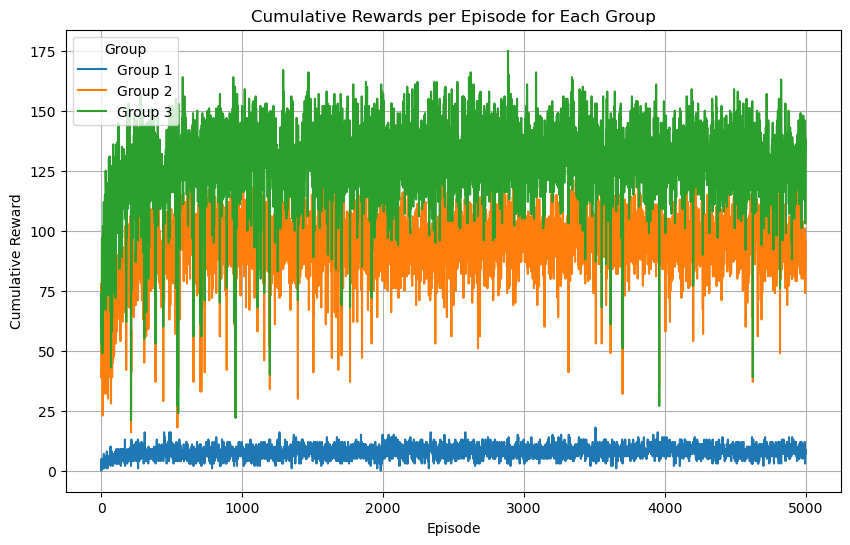

In [ ]:
import itertools
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# Environment parameters
num_groups = 3  # Patient groups: Low Risk, Medium Risk, High Risk
total_organs = 50  # Initial organ supply
time_horizon = 30  # Ischemic time limit (discrete time steps)
num_episodes = 5000  # Number of Q-learning episodes

epsilon = 0.8
alpha = 0.9
gamma = 0.99

# Patient group parameters
alpha_params = [5, 25, 9]  # Alpha parameters for urgency Beta distribution
beta_params = [25, 10, 1]  # Beta parameters for urgency Beta distribution

# Initialize Q-tables for each group
group_Q_tables = [
    {(t, organs): [0] * 11 for t in range(time_horizon) for organs in range(total_organs + 1)}
    for _ in range(num_groups)
]

# Define urgency sampling function
def sample_urgency(group_id):
    alpha, beta = alpha_params[group_id], beta_params[group_id]
    return np.round(np.random.beta(alpha, beta) * 10, 2)  # Scaled urgency [0, 10]

# Initialize state
def initialize_state():
    return {
        "time": 0,
        "organs": total_organs,
        "patient_groups": [{"matched_organs": 0} for _ in range(num_groups)],
    }

# Transition function
def decentralized_transition(state, actions):
    new_state = {
        "time": state["time"] + 1,
        "organs": state["organs"],
        "patient_groups": [],
    }
    rewards = [0] * num_groups
    total_allocation = 0

    for group_id, priority in enumerate(actions):
        urgency = sample_urgency(group_id)
        #print(f"Group {group_id}: Urgency={urgency}, Priority={priority}")
        matched_organs = 0
        if urgency > priority and new_state["organs"] > 0:
            matched_organs = 1
            total_allocation += 1

        #print(f"Group {group_id}: Matched Organs={matched_organs}")
        new_state["patient_groups"].append({"matched_organs": matched_organs})
        rewards[group_id] = matched_organs * priority

    new_state["organs"] = max(0, state["organs"] - total_allocation)
    #print(f"New State Organs={new_state['organs']}, Rewards={rewards}")
    return new_state, rewards

# Compute Nash equilibrium
def compute_nash_equilibrium(group_Q_tables, state):
    actions = []
    for group_id in range(num_groups):
        group_state = (state["time"], state["organs"])
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, 10)  # Explore
        else:
            action = np.argmax(group_Q_tables[group_id][group_state])  # Exploit
        actions.append(action)
    return actions

# Track cumulative rewards
group_rewards_per_episode = {group_id: [] for group_id in range(num_groups)}

# Q-learning loop       
for episode in range(num_episodes):
    if episode % 500 == 0:
        print(f"Episode {episode+1}/{num_episodes}")
    state = initialize_state()
    total_rewards = [0] * num_groups

    for t in range(time_horizon):
        if state["organs"] <= 0:
            break

        # Compute Nash equilibrium actions
        actions = compute_nash_equilibrium(group_Q_tables, state)

        # Perform decentralized transition and get rewards
        next_state, rewards = decentralized_transition(state, actions)

        # Update Q-tables for each agent
        for group_id in range(num_groups):
            group_state = (state["time"], state["organs"])
            next_group_state = (next_state["time"], next_state["organs"])
            best_next_action = np.argmax(group_Q_tables[group_id][next_group_state])
            group_Q_tables[group_id][group_state][actions[group_id]] += alpha * (
                rewards[group_id] + gamma * group_Q_tables[group_id][next_group_state][best_next_action]
                - group_Q_tables[group_id][group_state][actions[group_id]]
            )

        state = next_state
        total_rewards = [r + tr for r, tr in zip(total_rewards, rewards)]

    # Log cumulative rewards
    for group_id in range(num_groups):
        group_rewards_per_episode[group_id].append(total_rewards[group_id])

    epsilon = max(0.1, epsilon * 0.99)  # Decay epsilon

# Plot cumulative rewards per episode
plt.figure(figsize=(10, 6))
for group_id in range(num_groups):
    plt.plot(group_rewards_per_episode[group_id], label=f"Group {group_id + 1}")

plt.title("Cumulative Rewards per Episode for Each Group")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend(title="Group")
plt.grid()
plt.show()


## Nash Q-Learning 
Mult ppl per group

Episode 1/5000
Episode 501/5000
Episode 1001/5000
Episode 1501/5000
Episode 2001/5000
Episode 2501/5000
Episode 3001/5000
Episode 3501/5000
Episode 4001/5000
Episode 4501/5000


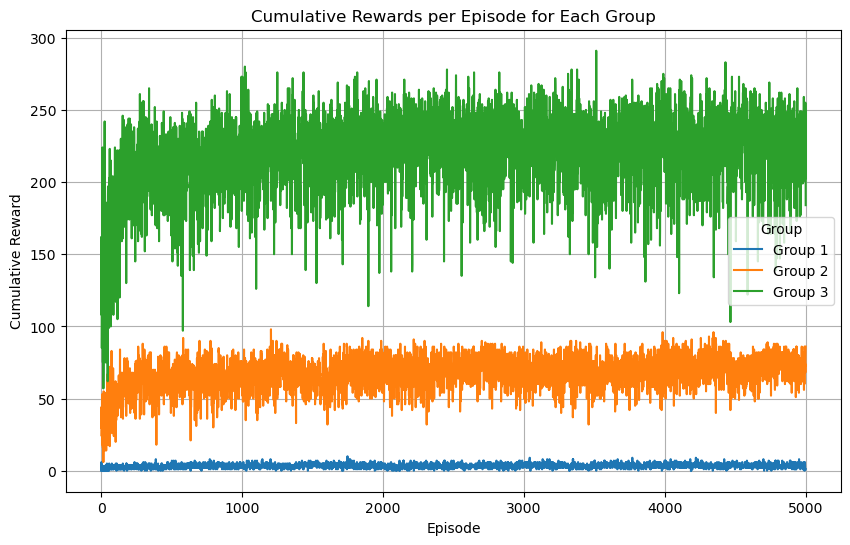

In [55]:
import itertools
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# Environment parameters
num_groups = 3  # Patient groups: Low Risk, Medium Risk, High Risk
total_organs = 50  # Initial organ supply
time_horizon = 30  # Ischemic time limit (discrete time steps)
num_episodes = 5000  # Number of Q-learning episodes

patients_per_group = {1: 1, 2: 2, 3: 5}

epsilon = 0.8
alpha = 0.9
gamma = 0.99

# Patient group parameters
alpha_params = [5, 25, 9]  # Alpha parameters for urgency Beta distribution
beta_params = [25, 10, 1]  # Beta parameters for urgency Beta distribution

# Initialize Q-tables for each group
group_Q_tables = [
    {(t, organs): [0] * 11 for t in range(time_horizon) for organs in range(total_organs + 1)}
    for _ in range(num_groups)
]

# Define urgency sampling function
def sample_urgency(group_id):
    alpha, beta = alpha_params[group_id], beta_params[group_id]
    return np.round(np.random.beta(alpha, beta) * 10, 2)  # Scaled urgency [0, 10]

# Initialize state
def initialize_state():
    return {
        "time": 0,
        "organs": total_organs,
        "patient_groups": [{"matched_organs": 0} for _ in range(num_groups)],
    }

# Transition function with multiple patients per group
def decentralized_transition(state, actions):
    new_state = {
        "time": state["time"] + 1,
        "organs": state["organs"],
        "patient_groups": [],
    }
    rewards = [0] * num_groups
    total_allocation = 0

    for group_id, priority in enumerate(actions):
        matched_organs = 0
        for _ in range(patients_per_group[group_id + 1]):  # Iterate over patients in the group
            urgency = sample_urgency(group_id)
            if urgency > priority and new_state["organs"] > 0:
                matched_organs += 1
                new_state["organs"] -= 1
                total_allocation += 1
        new_state["patient_groups"].append({"matched_organs": matched_organs})
        rewards[group_id] = matched_organs * priority

    new_state["organs"] = max(0, new_state["organs"])  # Ensure non-negative organ count
    return new_state, rewards

# Compute Nash equilibrium
def compute_nash_equilibrium(group_Q_tables, state):
    actions = []
    for group_id in range(num_groups):
        group_state = (state["time"], state["organs"])
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, 10)  # Explore
        else:
            action = np.argmax(group_Q_tables[group_id][group_state])  # Exploit
        actions.append(action)
    return actions

# Track cumulative rewards
group_rewards_per_episode = {group_id: [] for group_id in range(num_groups)}

# Q-learning loop
for episode in range(num_episodes):
    if episode % 500 == 0:
        print(f"Episode {episode+1}/{num_episodes}")
    state = initialize_state()
    total_rewards = [0] * num_groups

    for t in range(time_horizon):
        if state["organs"] <= 0:
            break

        # Compute Nash equilibrium actions
        actions = compute_nash_equilibrium(group_Q_tables, state)

        # Perform decentralized transition and get rewards
        next_state, rewards = decentralized_transition(state, actions)

        # Update Q-tables for each agent
        for group_id in range(num_groups):
            group_state = (state["time"], state["organs"])
            next_group_state = (next_state["time"], next_state["organs"])
            best_next_action = np.argmax(group_Q_tables[group_id][next_group_state])
            q_update = rewards[group_id] + gamma * group_Q_tables[group_id][next_group_state][best_next_action]
            group_Q_tables[group_id][group_state][actions[group_id]] += alpha * (
                q_update - group_Q_tables[group_id][group_state][actions[group_id]]
            )

        state = next_state
        total_rewards = [r + tr for r, tr in zip(total_rewards, rewards)]

    # Log cumulative rewards
    for group_id in range(num_groups):
        group_rewards_per_episode[group_id].append(total_rewards[group_id])

    epsilon = max(0.1, epsilon * 0.99)  # Decay epsilon

# Plot cumulative rewards per episode
plt.figure(figsize=(10, 6))
for group_id in range(num_groups):
    plt.plot(group_rewards_per_episode[group_id], label=f"Group {group_id + 1}")

plt.title("Cumulative Rewards per Episode for Each Group")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend(title="Group")
plt.grid()
plt.show()


# Add in age + MELD
Instead of Beta